## Week 1: Data Exploration and Cleaning

In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Set plot style
sns.set(style="whitegrid")




In [43]:
# Loading the dataset
data = pd.read_csv('credit_risk.csv')

In [44]:

data_types = data.dtypes
print("Data Types of Columns:")
print(data_types)

Data Types of Columns:
Id                  int64
Age                 int64
Income              int64
Home               object
Emp_length        float64
Intent             object
Amount              int64
Rate              float64
Status              int64
Percent_income    float64
Default            object
Cred_length         int64
dtype: object


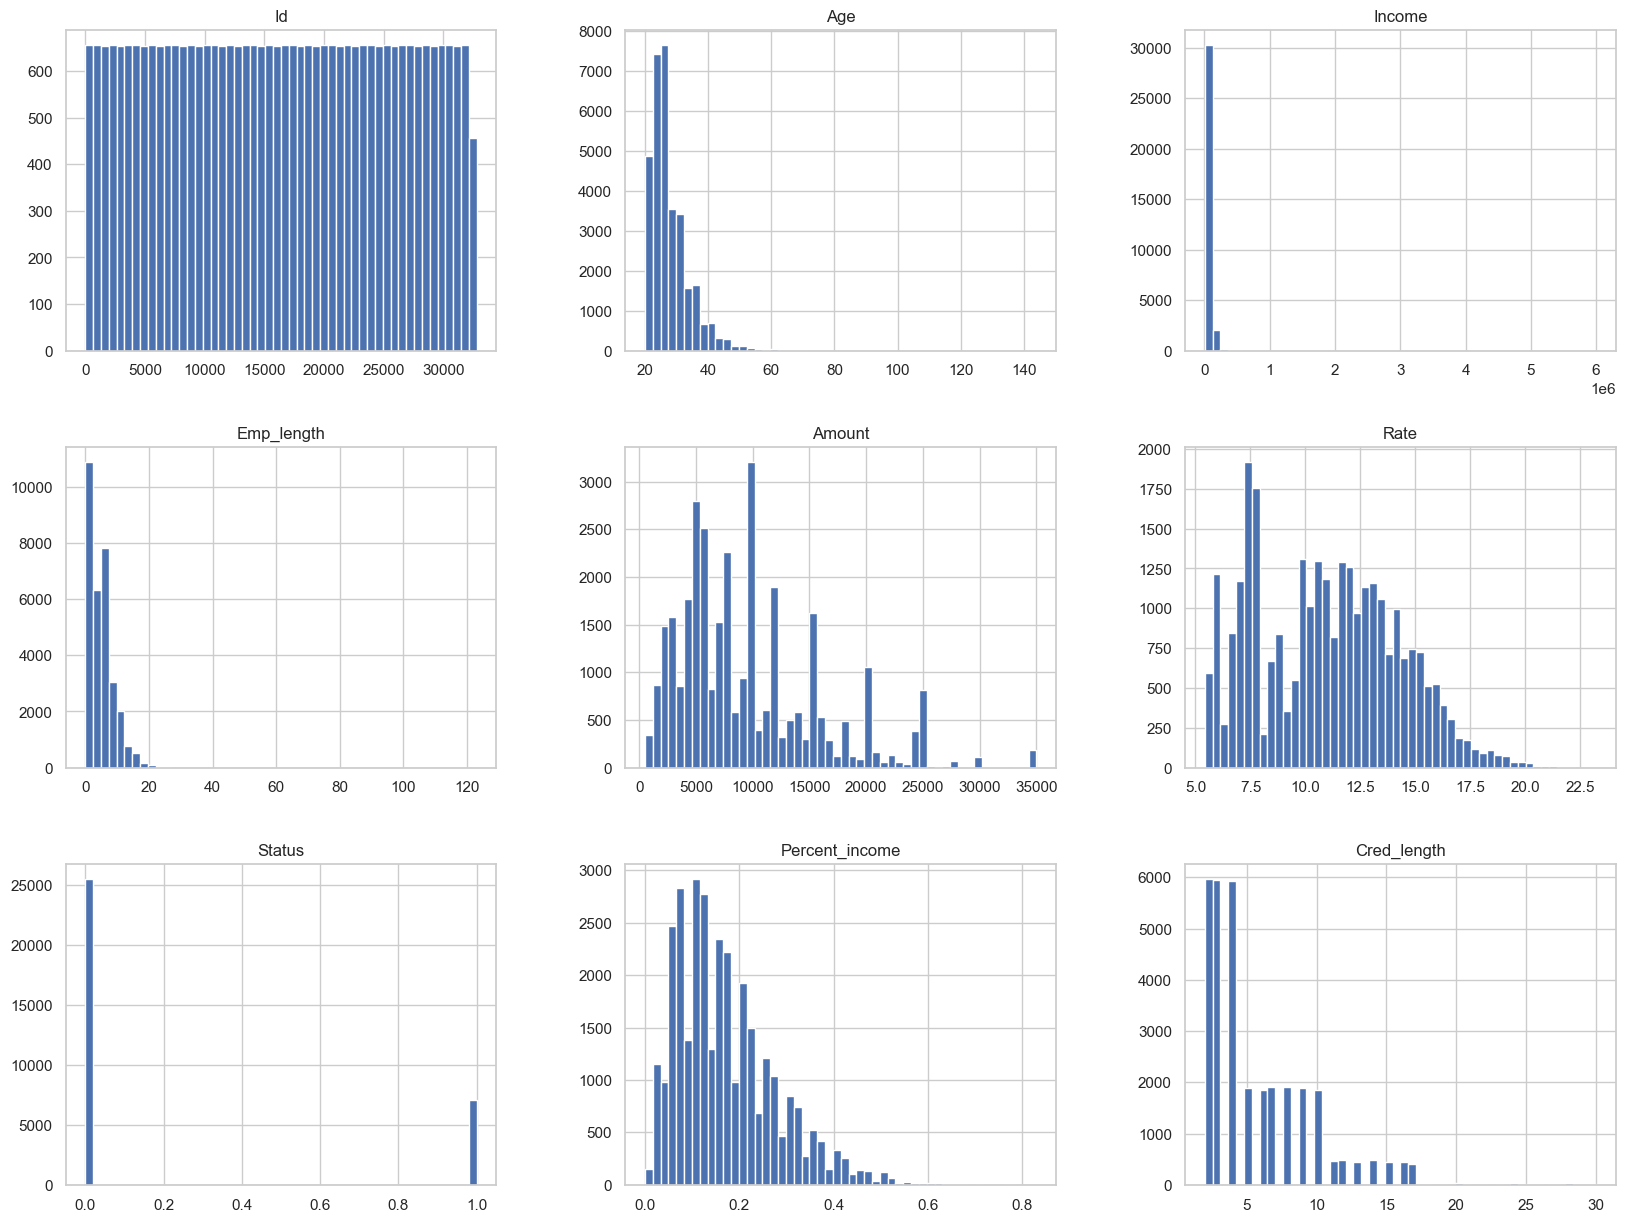

In [45]:
data.hist(bins=50, figsize=(20,15)) 
plt.show()

In [46]:
#data summary
print("\nData Summary:")
print(data.info())


Data Summary:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Id              32581 non-null  int64  
 1   Age             32581 non-null  int64  
 2   Income          32581 non-null  int64  
 3   Home            32581 non-null  object 
 4   Emp_length      31686 non-null  float64
 5   Intent          32581 non-null  object 
 6   Amount          32581 non-null  int64  
 7   Rate            29465 non-null  float64
 8   Status          32581 non-null  int64  
 9   Percent_income  32581 non-null  float64
 10  Default         32581 non-null  object 
 11  Cred_length     32581 non-null  int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 3.0+ MB
None


In [47]:
# Checking for duplicate entries
duplicate_entries = data.duplicated().sum()
print("Duplicate Entries:", duplicate_entries)

Duplicate Entries: 0


In [48]:
# Identify missing values
missing_values = data.isnull().sum()
missing_percentage = (data.isnull().sum() / len(data)) * 100
missing_data = pd.DataFrame({'Missing Values': missing_values, 'Percentage': missing_percentage})
print(missing_data)


                Missing Values  Percentage
Id                           0    0.000000
Age                          0    0.000000
Income                       0    0.000000
Home                         0    0.000000
Emp_length                 895    2.747000
Intent                       0    0.000000
Amount                       0    0.000000
Rate                      3116    9.563856
Status                       0    0.000000
Percent_income               0    0.000000
Default                      0    0.000000
Cred_length                  0    0.000000


In [49]:
# Check for initial missing values
initial_missing_values = data[['Emp_length', 'Rate']].isnull().sum()
print("Initial missing values:")
print(initial_missing_values)


Initial missing values:
Emp_length     895
Rate          3116
dtype: int64


In [50]:
# Fill missing values with mean
data['Emp_length'].fillna(data['Emp_length'].mean(), inplace=True)
data['Rate'].fillna(data['Rate'].mean(), inplace=True)

In [51]:
# Verify missing values have been filled
missing_values_after = data[['Emp_length', 'Rate']].isnull().sum()
print("\nMissing values after filling:")
print(missing_values_after)


Missing values after filling:
Emp_length    0
Rate          0
dtype: int64


In [52]:
#checking if the missing values has been filled
missing_values = data.isnull().sum()
missing_percentage = (data.isnull().sum() / len(data)) * 100
missing_data = pd.DataFrame({'Missing Values': missing_values, 'Percentage': missing_percentage})
print(missing_data)

                Missing Values  Percentage
Id                           0         0.0
Age                          0         0.0
Income                       0         0.0
Home                         0         0.0
Emp_length                   0         0.0
Intent                       0         0.0
Amount                       0         0.0
Rate                         0         0.0
Status                       0         0.0
Percent_income               0         0.0
Default                      0         0.0
Cred_length                  0         0.0


In [53]:


# Identify outliers using IQR for 'emp_length' and 'rate' columns

# Identify outliers using IQR for 'emp_length' and 'rate' columns
def detect_outliers_iqr(data):
    outliers = pd.DataFrame()
    columns = ['Emp_length', 'Rate']
    for column in columns:
        Q1 = data[column].quantile(0.25)
        Q3 = data[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers[column] = data[column].apply(lambda x: x < lower_bound or x > upper_bound)
    return outliers

outliers = detect_outliers_iqr(data)
outliers_summary = outliers.sum()
print(outliers_summary)

Emp_length    853
Rate           70
dtype: int64


In [54]:
# Remove outliers from the dataframe
filtered_data = data[~(outliers['Emp_length'] | outliers['Rate'])]

In [55]:
# Display the shape of the filtered dataframe
print("Shape of original dataframe:", data.shape)
print("Shape of filtered dataframe after removing outliers:", filtered_data.shape)

Shape of original dataframe: (32581, 12)
Shape of filtered dataframe after removing outliers: (31659, 12)


In [56]:
# Identify inconsistent data entries
categorical_columns = data.select_dtypes(include=['object']).columns
for column in categorical_columns:
    print(f"Unique values in {column}:")
    print(data[column].value_counts())
    print("\n")

Unique values in Home:
Home
RENT        16446
MORTGAGE    13444
OWN          2584
OTHER         107
Name: count, dtype: int64


Unique values in Intent:
Intent
EDUCATION            6453
MEDICAL              6071
VENTURE              5719
PERSONAL             5521
DEBTCONSOLIDATION    5212
HOMEIMPROVEMENT      3605
Name: count, dtype: int64


Unique values in Default:
Default
N    26836
Y     5745
Name: count, dtype: int64




### Data Quality Report

In [57]:
# Save missing values and outliers summary to a report
with open('data_quality_report.txt', 'w') as f:
    f.write("Missing Values and Percentage:\n")
    f.write(missing_data.to_string())
    f.write("\n\nOutliers Summary:\n")
    f.write(outliers_summary.to_string())

# Data Preparation Pipeline


In [58]:
def clean_data(data):
    # Handle missing values
    data['Emp_length'].fillna(data['Emp_length'].median(), inplace=True)
    
    # Handle inconsistent entries (if any, based on earlier findings)
    # Example: standardizing categories
    data['Home'] = data['Home'].str.lower()
    data['Intent'] = data['Intent'].str.lower()
    
    # Encode categorical variables
    data = pd.get_dummies(data, columns=['Home', 'Intent'], drop_first=True)
    
    
    return data

data_cleaned = clean_data(data)
data_cleaned.to_csv('cleaned_credit_risk.csv', index=False)

# Week 2

## Exploratory Data Analysis (EDA)

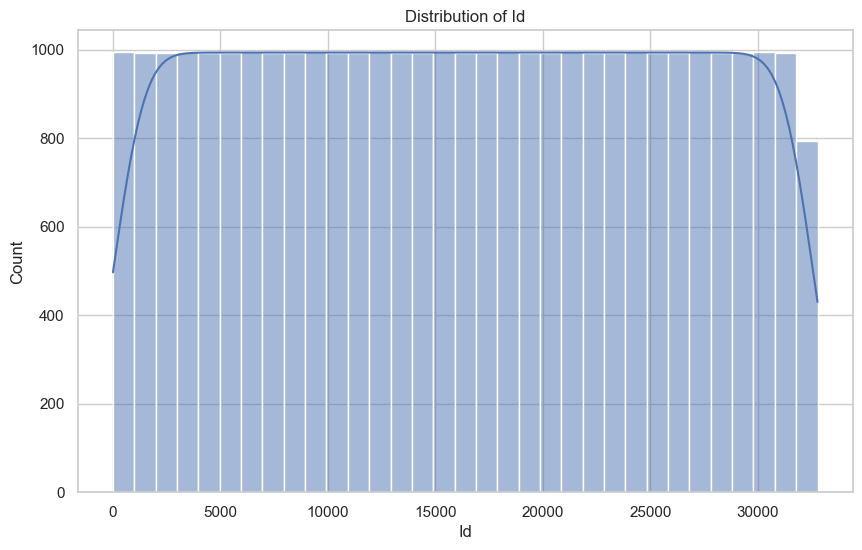

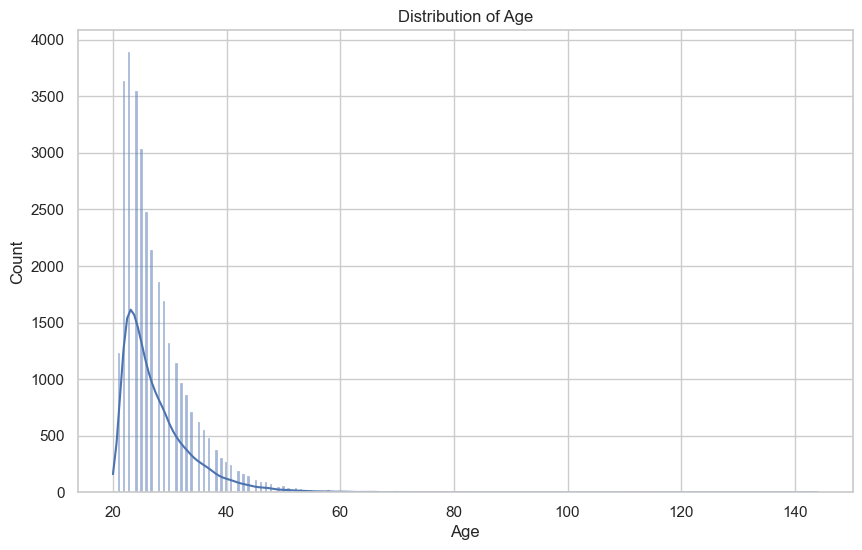

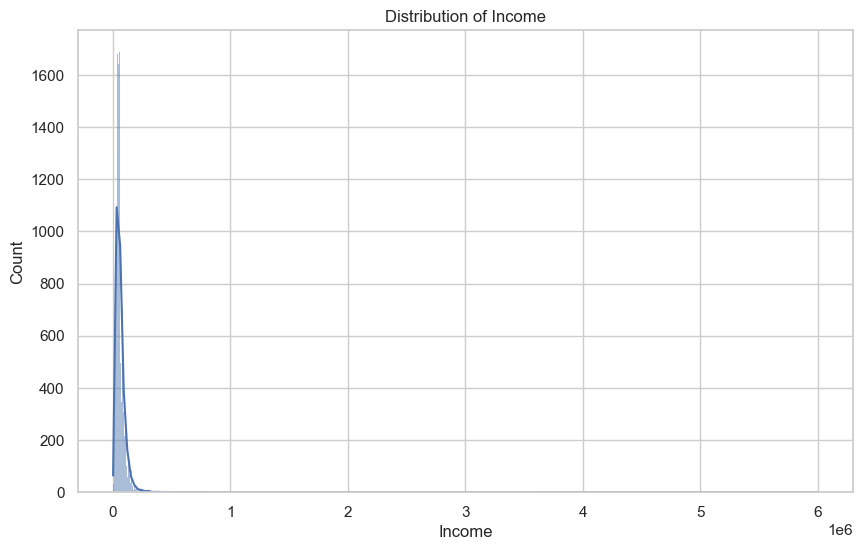

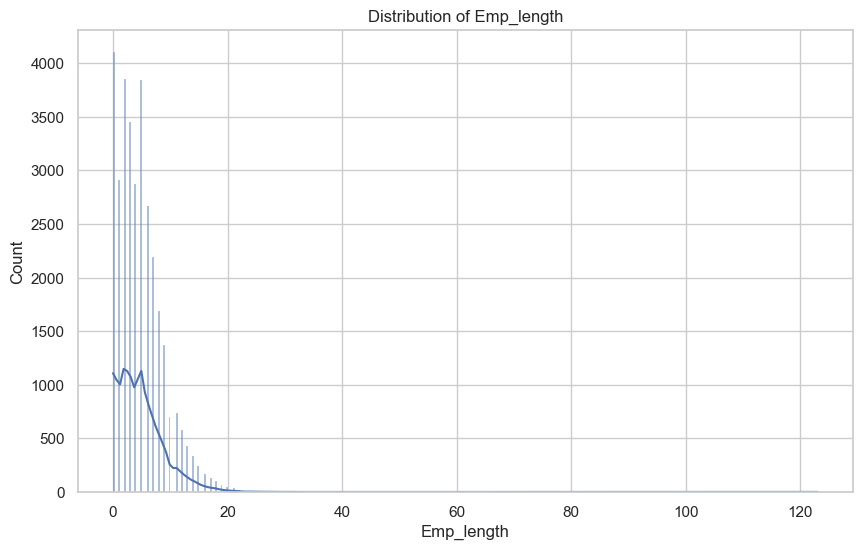

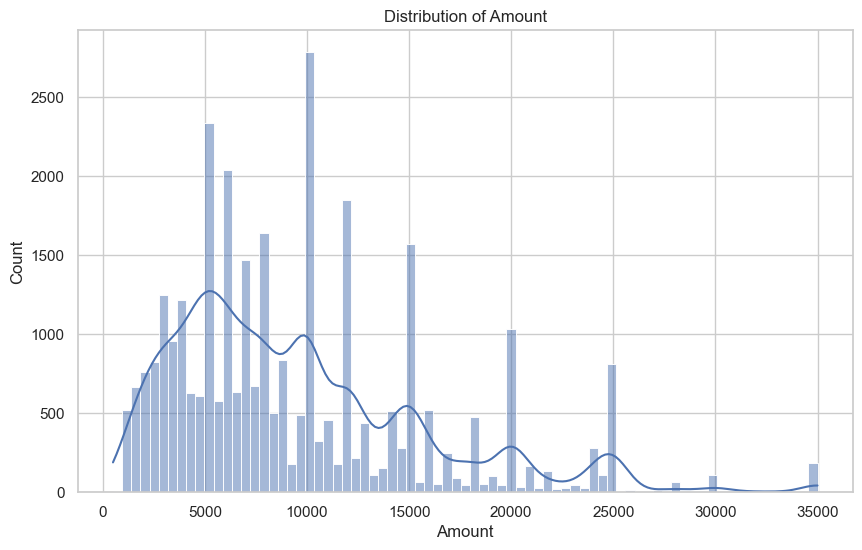

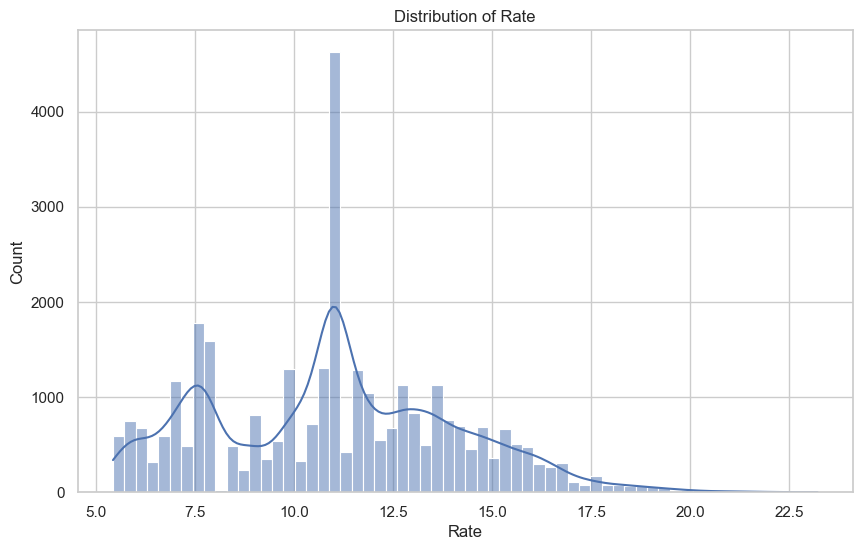

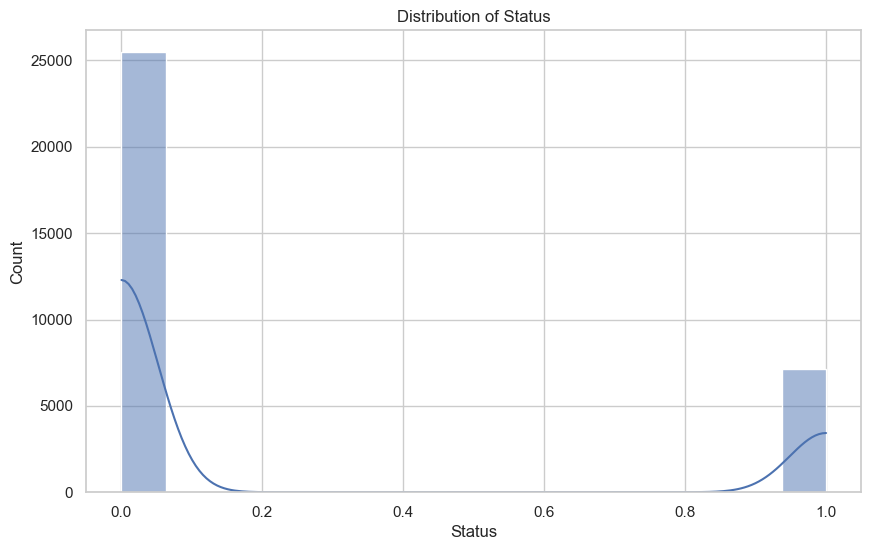

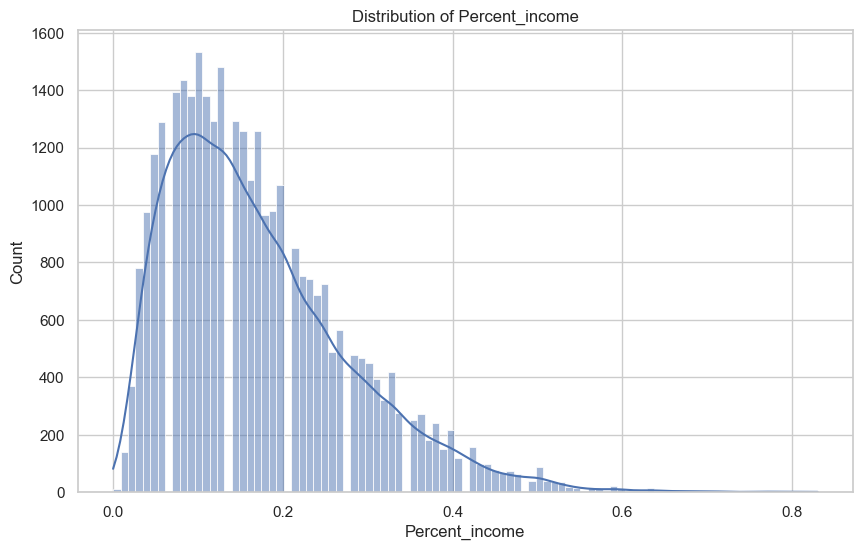

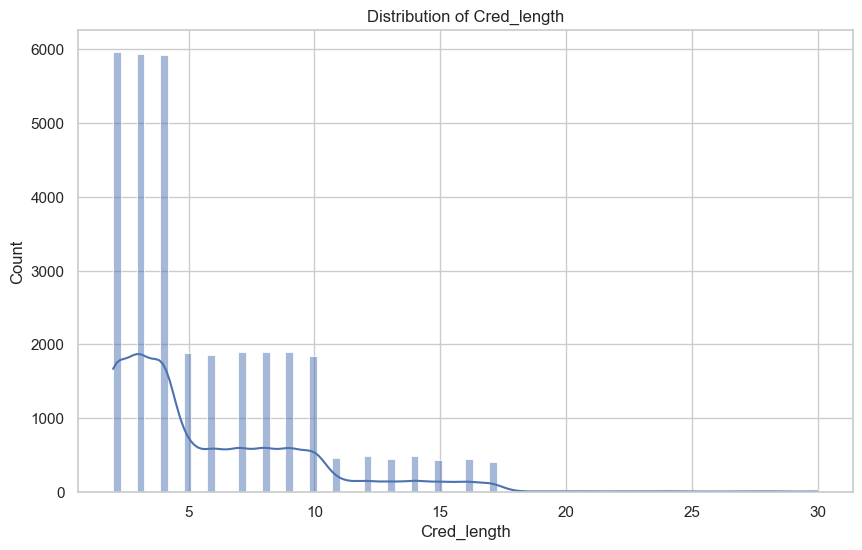

In [59]:
#Create Visualizations:
# Distribution of numerical variables

for column in data_cleaned.select_dtypes(include=[np.number]).columns:
    plt.figure(figsize=(10, 6))
    sns.histplot(data_cleaned[column], kde=True)
    plt.title(f'Distribution of {column}')
    plt.show()

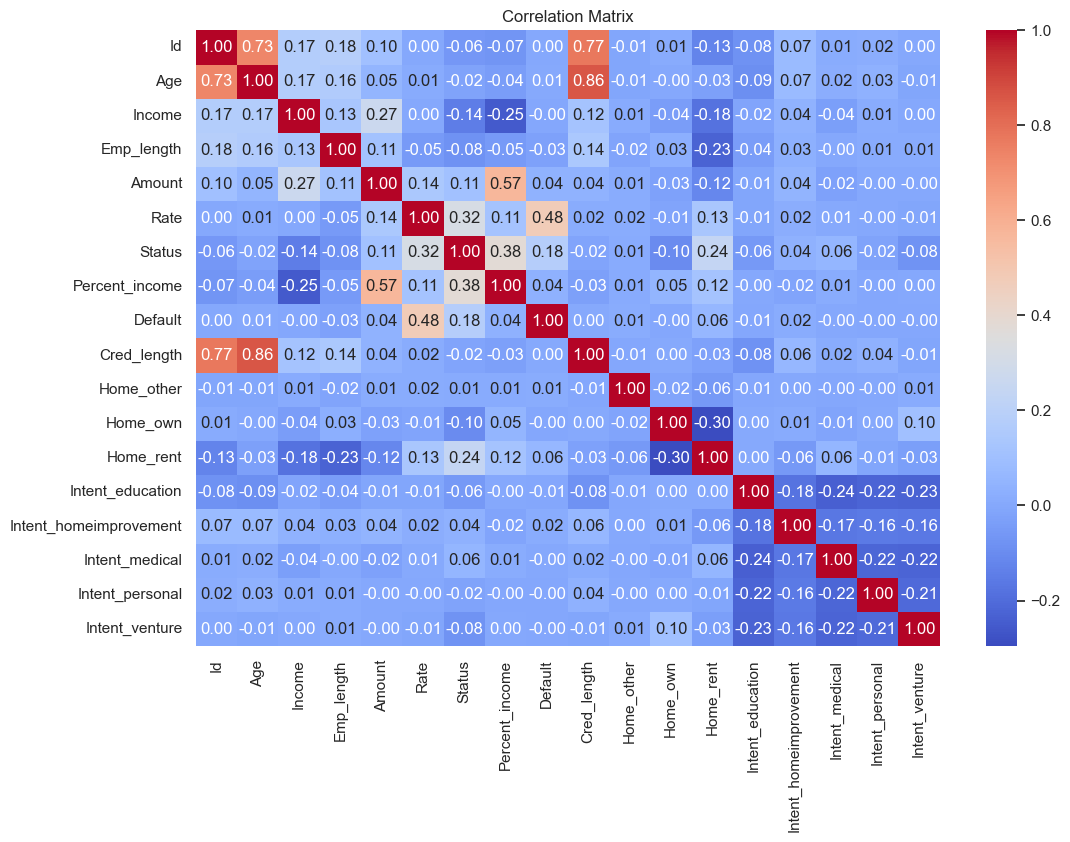

In [60]:
# Convert categorical column 'emp_length' to numeric
data_cleaned['Default'] = data_cleaned['Default'].apply(lambda x: 1 if x == 'Y' else 0)

# Correlation matrix
plt.figure(figsize=(12, 8))
correlation_matrix = data_cleaned.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

## Preprocessing


In [61]:
# Define columns
numerical_features = data_cleaned.select_dtypes(include=['int64', 'float64']).columns
categorical_features = data_cleaned.select_dtypes(include=['object']).columns

numerical_features



Index(['Id', 'Age', 'Income', 'Emp_length', 'Amount', 'Rate', 'Status',
       'Percent_income', 'Default', 'Cred_length'],
      dtype='object')

In [62]:
categorical_features


Index([], dtype='object')

In [63]:
data_cleaned.head()

,Id,Age,Income,Emp_length,Amount,Rate,Status,Percent_income,Default,Cred_length,Home_other,Home_own,Home_rent,Intent_education,Intent_homeimprovement,Intent_medical,Intent_personal,Intent_venture
0,0,22,59000,123.0,35000,16.02,1,0.59,1,3,False,False,True,False,False,False,True,False
1,1,21,9600,5.0,1000,11.14,0,0.10,0,2,False,True,False,True,False,False,False,False
2,2,25,9600,1.0,5500,12.87,1,0.57,0,3,False,False,False,False,False,True,False,False
3,3,23,65500,4.0,35000,15.23,1,0.53,0,2,False,False,True,False,False,True,False,False
4,4,24,54400,8.0,35000,14.27,1,0.55,1,4,False,False,True,False,False,True,False,False


In [64]:
# Imputers for missing values
numerical_imputer = SimpleImputer(strategy='mean')
categorical_imputer = SimpleImputer(strategy='most_frequent')

In [65]:
# Encoder for categorical features
categorical_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

 #Normalize Numerical Features
scaler = StandardScaler()

In [66]:
# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', numerical_imputer),
            ('scaler', scaler)]), numerical_features),
        ('cat', Pipeline(steps=[
            ('imputer', categorical_imputer),
            ('encoder', categorical_encoder)]), categorical_features)
    ])


###  "Feature Engineering for Credit Scoring Models"


In [67]:
# Creating interaction terms
data_cleaned['Age_Income'] = data_cleaned['Age'] * data_cleaned['Income']
data_cleaned['Income_Amount'] = data_cleaned['Income'] / data_cleaned['Amount']

In [68]:
# Testing transformations
data_cleaned['Log_Income'] = np.log(data_cleaned['Income'] + 1) # Log transformation
data_cleaned['Square_Age'] = data_cleaned['Age'] ** 2 # Polynomial transformation

data_cleaned.to_csv('engineered_credit_risk.csv', index=False)

# Week 3: Model Development

In [69]:
data_cleaned = pd.read_csv('engineered_credit_risk.csv')
print(data_cleaned.head())


   Id  Age  Income  Emp_length  Amount   Rate  Status  Percent_income  \
0   0   22   59000       123.0   35000  16.02       1            0.59   
1   1   21    9600         5.0    1000  11.14       0            0.10   
2   2   25    9600         1.0    5500  12.87       1            0.57   
3   3   23   65500         4.0   35000  15.23       1            0.53   
4   4   24   54400         8.0   35000  14.27       1            0.55   

   Default  Cred_length  ...  Home_rent  Intent_education  \
0        1            3  ...       True             False   
1        0            2  ...      False              True   
2        0            3  ...      False             False   
3        0            2  ...       True             False   
4        1            4  ...       True             False   

   Intent_homeimprovement  Intent_medical  Intent_personal  Intent_venture  \
0                   False           False             True           False   
1                   False           Fa

In [70]:
# Create a copy of the DataFrame to retain the original 'Default' column
data_with_default = data_cleaned.copy()

In [71]:
from sklearn.preprocessing import LabelEncoder

# Initialize label encoder
label_encoder = LabelEncoder()

# Fit and transform the target variable 'Default' using label encoder and store the encoded values back in the 'Default' column
data_with_default['Default'] = label_encoder.fit_transform(data_with_default['Default'])

# Define X and y
X = data_with_default.drop('Default', axis=1)  # Features (input data)
y = data_with_default['Default']  # Target variable (output / label)

In [72]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train a logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Evaluate the model
accuracy = model.score(X_test, y_test)
print(f"Model accuracy: {accuracy}")

C:\Users\USER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model accuracy: 0.8166334202854074


In [73]:


# Initialize and train a logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

C:\Users\USER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [74]:
# Predict on the test set
y_pred = model.predict(X_test)

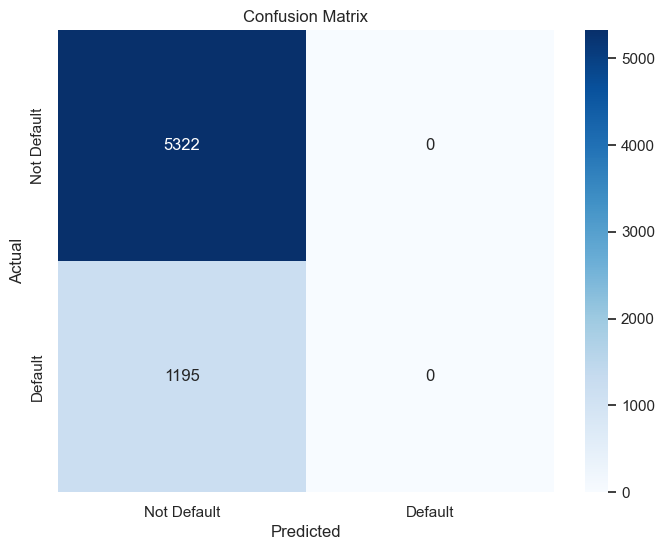

In [75]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', 
            xticklabels=['Not Default', 'Default'], 
            yticklabels=['Not Default', 'Default'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

### Random Forest, Gradient Boosting Machines, and Neural Networks


## Random Forest

In [76]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))

Random Forest Accuracy: 0.8203160963633573


### Gradient Boosting

In [77]:
gb = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb.fit(X_train, y_train)
y_pred_gb = gb.predict(X_test)
print("Gradient Boosting Accuracy:", accuracy_score(y_test, y_pred_gb))

Gradient Boosting Accuracy: 0.8272211140095136


### Neural Network

In [78]:
mlp = MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=42)
mlp.fit(X_train, y_train)
y_pred_mlp = mlp.predict(X_test)
print("Neural Network Accuracy:", accuracy_score(y_test, y_pred_mlp))

Neural Network Accuracy: 0.8166334202854074


 Gradient Boosting has the highest accuracy at 0.8272, followed closely by Random Forest at 0.8203, and then both Neural Network and Logistic Regression with an accuracy of 0.8166.

# Week 4 - Model Deployment and Reporting

In [79]:

import joblib

# Saving the best performing model
best_model = mlp 
joblib.dump(best_model, 'credit_scoring_model.pkl')

['credit_scoring_model.pkl']